# dataset 

In [2]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [3]:
dataset = Cityscapes('./data', split='train', mode='fine',
                      target_type='semantic')

In [4]:
dataset[0][0].size

(2048, 1024)

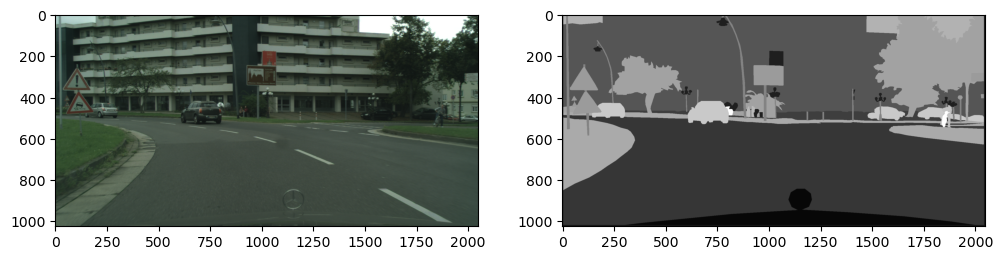

In [5]:
fig,ax=plt.subplots(ncols=2,figsize=(12,8))
ax[0].imshow(dataset[0][0])
ax[1].imshow(dataset[0][1],cmap='gray')

# some utility functions

In [6]:
#label understanding
#https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py

#function credits: https://github.com/meetps/pytorch-semseg/tree/master/ptsemseg

In [7]:
ignore_index=255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
valid_classes = [ignore_index,7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
               'train', 'motorcycle', 'bicycle']
#why i choose 20 classes
#https://stackoverflow.com/a/64242989

class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{255: 0,
 7: 1,
 8: 2,
 11: 3,
 12: 4,
 13: 5,
 17: 6,
 19: 7,
 20: 8,
 21: 9,
 22: 10,
 23: 11,
 24: 12,
 25: 13,
 26: 14,
 27: 15,
 28: 16,
 31: 17,
 32: 18,
 33: 19}

In [8]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colours = dict(zip(range(n_classes), colors))

In [9]:
def encode_segmap(mask):
    #remove unwanted classes and recitify the labels of wanted classes
    for _voidc in void_classes:
        mask[mask == _voidc] = ignore_index
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [10]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb


In [11]:
#pip uninstall albumentations
#!pip3 install albumentations
#!pip install --user typing_extensions
#pip install typing-extensions
#!pip3 install typing-extensions
#from typing_extensions import Concatenate

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)


In [13]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple
from torchvision.datasets import Cityscapes

class MyClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        image = Image.open(self.images[index]).convert('RGB')

        targets: Any = []
        for i, t in enumerate(self.target_type):
            if t == 'polygon':
                target = self._load_json(self.targets[index][i])
            else:
                target = Image.open(self.targets[index][i])
            targets.append(target)
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms is not None:
            transformed=transform(image=np.array(image), mask=np.array(target))            
        return transformed['image'],transformed['mask']
    #torch.unsqueeze(transformed['mask'],0)

In [14]:
dataset=MyClass('./data', split='train', mode='fine',
                     target_type='semantic', transforms=transform)

img,seg= dataset[0]
print(img.shape,seg.shape)

torch.Size([3, 256, 512]) torch.Size([256, 512])


In [15]:
dataset

Dataset MyClass
    Number of datapoints: 480
    Root location: ./data
    Split: train
    Mode: gtFine
    Type: ['semantic']
    Compose([
  Resize(always_apply=False, p=1, height=256, width=512, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  Normalize(always_apply=False, p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


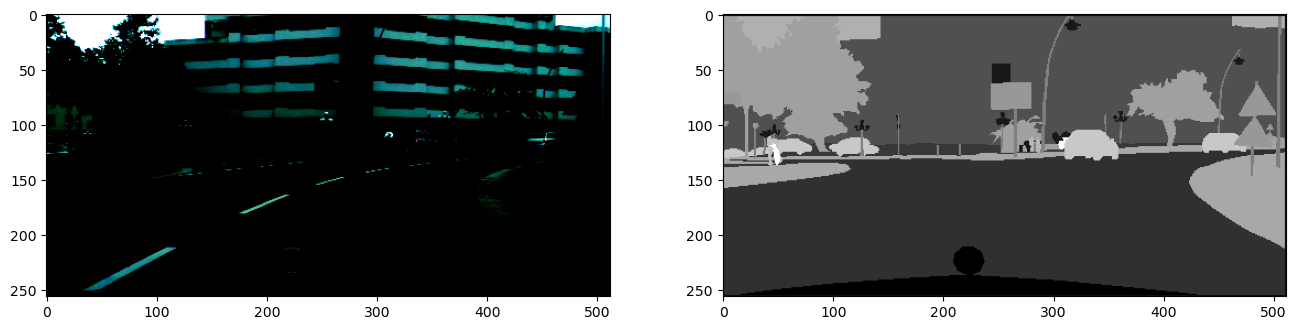

In [16]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(seg,cmap='gray')

In [17]:
#class labels before label correction
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([ 1,  3,  4,  7,  8, 11, 17, 20, 21, 22, 23, 24, 25, 26, 33],
       dtype=torch.uint8)
15


In [18]:
#class labels after label correction
res=encode_segmap(seg.clone())
print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))


torch.Size([256, 512])
tensor([ 0,  1,  2,  3,  6,  8,  9, 10, 11, 12, 13, 14, 19], dtype=torch.uint8)
13


In [19]:
#let do coloring
res1=decode_segmap(res.clone())


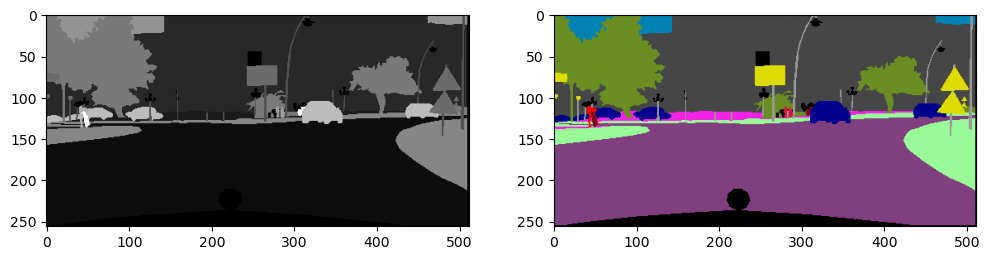

In [20]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res1)

# training

In [21]:
# model=torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
# model

In [22]:
#!pip install pytorch-lightning

In [23]:
#!pip install segmentation_models_pytorch

In [24]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp

from pytorch_lightning import seed_everything, LightningModule, Trainer
import multiprocessing
import torchmetrics
import torch
import torchvision.models as models
import gc
from torchmetrics import RetrievalMAP
from torchmetrics.functional import retrieval_average_precision

In [25]:
dataset=MyClass('./data', split='train', mode='fine',
                     target_type='semantic', transforms=transform)

In [26]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True) #num_worker

In [27]:
len(train_dataloader)

24

In [28]:
n_classes

20

In [ ]:
#Model = models.segmentation.deeplabv3_resnet101(pretrained=1)
#Model = models.segmentation.deeplabv3_resnet50(pretrained=1,in_channels=3,classes=n_classes)

In [ ]:
#Model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",in_channels=3, classes=n_classes )

Model = smp.Unet(encoder_name="resnet101", encoder_weights="imagenet",in_channels=3, classes=n_classes )

In [ ]:
optimizer = torch.optim.AdamW(Model.parameters(), lr=1e-3)
metrics = torchmetrics.JaccardIndex(num_classes=n_classes)
criterion= smp.losses.DiceLoss(mode='multiclass')
rmap = RetrievalMAP()

In [ ]:
Model.eval()

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    print('epoch', epoch)

    running_loss = 0.0
    running_iou = 0.0
    for i, data in enumerate(train_dataloader, 0):
        
        # get the inputs
        inputs, labels = data
        #print(labels)

        # zero the parameter gradients
        #optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Model(inputs)
        
        #if isinstance(outputs, OrderedDict):
        outputs = outputs['out']
        segment=encode_segmap(labels)
        loss=criterion(outputs,segment.long())
        iou=metrics(outputs,segment)
        #rap = retrieval_average_precision(outputs,segment.long())
        #r_map = rmap(outputs,segment, indexes=class_map)
       
        #loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_iou += iou.item()
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, loss.item()),
              ', IoU:', iou.item())
    print('net loss ', running_loss, 'net iou', running_iou)


print('Finished Training')
torch.save(Model.state_dict(), 'model_unet_rn101.pth')

In [ ]:
model = Model
model.load_state_dict(torch.load('model_unet_rn101.pth'))
model = nn.DataParallel(model)
#Model.load_state_dict(torch.load('model_trained.pth'))
model.eval()

In [ ]:
test_class = MyClass('./data', split='train', mode='fine',
                     target_type='semantic',transforms=transform)
test_loader=DataLoader(test_class, batch_size=20, 
                      shuffle=False)

In [ ]:
len(test_loader)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
from torchvision import transforms
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)


In [ ]:

sample=6
invimg=inv_normalize(img[sample])
outputx=output.detach().cpu()[sample]
encoded_mask=encode_segmap(seg[sample].clone()) #(256, 512)
decoded_mask=decode_segmap(encoded_mask.clone())  #(256, 512)
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white')  
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) #(3,256, 512)
#ax[1].imshow(encoded_mask,cmap='gray') #(256, 512)
ax[1].imshow(decoded_mask) #(256, 512, 3)
ax[2].imshow(decoded_ouput) #(256, 512, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')
plt.savefig('result.png',bbox_inches='tight')